<a href="https://colab.research.google.com/github/bruckman/Gamma_Factory/blob/main/tracks_in_magnetic_field.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Charged particles in constant magnetic fields**

*Marcin Wolter, February 2021*

The equation of motion for a charged particle in a magnetic field is as follows:

$\frac{d\vec{v}}{dt}=qm(\vec{v} \times \vec{B} )$



Let's see how we can implement this using the integrators found in the scientific python stack.



In [183]:
# imports
import numpy as np
from scipy.integrate import ode

Here we define the magnetic field B

In [184]:
def B(xx):

  return Bv(xx[0], xx[1], xx[2])


def Bv(x, y, z):

  R1  = 1.
  R2  = 30.
  R3  = 40.
  R4  = 41.

  z_low =  -10
  z_high=  50

  r = np.sqrt(x*x + y*y)
  sin_phi = y/r
  cos_phi = x/r

  #  B0 = 0.025*(1-z/80)*(0.0+0.2*np.abs(r))
  B0 = 1.0*(1/np.abs(r))
  B1 = 0.85

  Bx = 0
  By = 0
  Bz = 0

  # magnetic lense with 2pi symmetry:
  if (r>R1 and r<R2 and z>z_low and z<z_high):
    Bx =  B0*cos_phi 
    By =  B0*sin_phi
    Bz =  B0*0.36       

  # toroidal field:
  if (r>R3-z*0.2 and r<R4-z*0.2 and z>z_low and z<z_high):
    #Bx =  -B1*sin_phi 
    #By =   B1*cos_phi
    Bz =   0        

  return [Bx,By,Bz] 

'''
  Bx = 0
  By = 0
  Bz = 1

  return [Bx,By,Bz]
'''

 

'\n  Bx = 0\n  By = 0\n  Bz = 1\n\n  return [Bx,By,Bz]\n'

To use ode, we need to define the derivatives of velocity, which is computed using the Lorentz force and of position, which is just velocity:

In [185]:
def newton(t, Y, q, m):
    """Computes the derivative of the state vector y according to the equation of motion:
    Y is the state vector (x, y, z, u, v, w) === (position, velocity).
    returns dY/dt.
    """
   
    #x, y, z = Y[0], Y[1], Y[2]
    #u, v, w = Y[3], Y[4], Y[5]

    alpha = q / m * np.cross(Y[3:],B(Y[:3]))

    Y_out = np.concatenate((Y[3:],alpha))

    return Y_out
    #return np.array([u, v, w, alpha[0], alpha[1], alpha[2]])

In [186]:
r = ode(newton).set_integrator('dopri5')

Let's now set the conditions on our integrators and solve the prolem using time stepping. We assume the charged particle has unit mass and unit charge.

In [187]:
def track(initial_conditions, t0, t1, q, m):
  r.set_initial_value(initial_conditions, t0).set_f_params(q, m) # initial parameters q, m

  positions = []
  
  dt = 0.05
  while r.successful() and r.t < t1:
      r.integrate(r.t+dt)
      positions.append(r.y[:3]) # keeping only position, not velocity

  return np.array(positions)

Finally, we need to define initial conditions and run tracking:



In [188]:
# initial conditions

# tracking of N_tracks particles
t0 = 0
t1 = 50
N_tracks=30

positions = []
Q = []

for i in range(N_tracks):
  z = np.random.uniform(0,30)
  phi   = np.random.uniform(0,2*3.1415)
  theta = np.random.uniform(40./180.*3.1415,100./180.*3.1415)
  vel = np.random.normal(1.0, 0.2)
  x0 = np.array([0, 0, z])
  v0 = np.array([np.sin(theta)*np.cos(phi)*vel, np.sin(theta)*np.sin(phi)*vel, np.cos(theta)*vel])
  initial_conditions = np.concatenate((x0, v0))

  q = np.random.randint(0,2)
  if q==0:
    q = -1
  m = 1.

  positions.append(track(initial_conditions, t0, t1, q, m))
  Q.append(q)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


Results in 2D

In [189]:
%matplotlib inline
import matplotlib.pyplot as plt

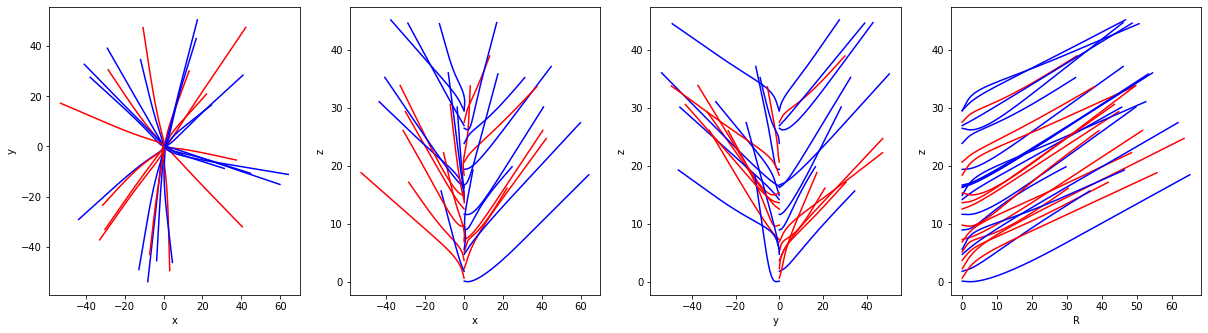

In [190]:
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.2)

ax = fig.add_subplot(1, 4, 1)
for i in range(len(positions)):
  if Q[i]>0:
    color = 'red'
  else:
    color = 'blue' 
  ax.plot(positions[i][:, 0], positions[i][:, 1], color=color)
  ax.set_xlabel('x')
  ax.set_ylabel('y')

ax = fig.add_subplot(1, 4, 2)
for i in range(len(positions)):
  if Q[i]>0:
    color = 'red'
  else:
    color = 'blue' 
  ax.plot(positions[i][:, 0], positions[i][:, 2], color=color)
  ax.set_xlabel('x')
  ax.set_ylabel('z')

ax = fig.add_subplot(1, 4, 3)
for i in range(len(positions)):
  if Q[i]>0:
    color = 'red'
  else:
    color = 'blue' 
  ax.plot(positions[i][:, 1], positions[i][:, 2], color=color)
  ax.set_xlabel('y')
  ax.set_ylabel('z')

ax = fig.add_subplot(1, 4, 4)
for i in range(len(positions)):
  if Q[i]>0:
    color = 'red'
  else:
    color = 'blue' 
  ax.plot(np.sqrt(positions[i][:, 0]*positions[i][:, 0] + positions[i][:, 1]*positions[i][:, 1]), positions[i][:, 2], color=color)
  ax.set_xlabel('R')
  ax.set_ylabel('z')

plt.show()


Results in 3D

In [191]:
import matplotlib as mpl

Text(0.5, 0, 'z')

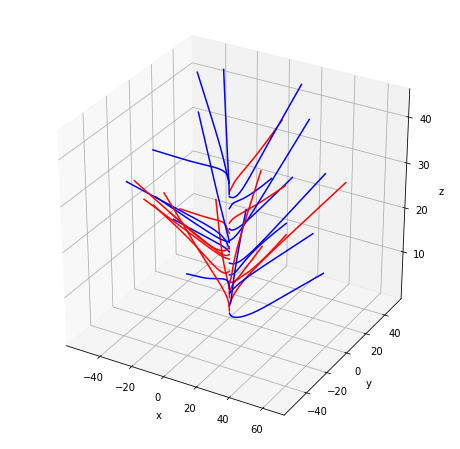

In [192]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(positions)):
  if Q[i]>0:
    color = 'red'
  else:
    color = 'blue'  
  ax.plot3D(positions[i][:, 0], positions[i][:, 1], positions[i][:, 2], color=color)
'''
B1 = np.array([x0[0], x0[1], -1])
B2 = np.array([60, 0, 0])
B_axis = np.vstack((B1, B1 + B2))
ax.plot3D(B_axis[:, 0], 
         B_axis[:, 1],
         B_axis[:, 2])
'''         
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
#ax.text3D((B1 + B2)[0], (B1 + B2)[1], (B1 + B2)[2], "B field")

Just for fun: found an example how to make a movie.

In [193]:
from tempfile import NamedTemporaryFile
import base64 
from matplotlib import animation
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        f = NamedTemporaryFile(suffix='.mp4', delete=False)
        anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
        f.flush()
        video = open(f.name, "rb").read()
        f.close()
        anim._encoded_video = base64.b64encode(video).decode('utf-8')
    
    return VIDEO_TAG.format(anim._encoded_video)

In [194]:
from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [195]:
FRAMES = 50
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

def init():
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
# animation function.  This is called sequentially
def animate(i):

  current_index = int(positions[0].shape[0] / FRAMES * i)
  ax.cla()
      
  for n in range(len(positions)):
      if Q[n]>0:
        color = 'red'
      else:
        color = 'blue'
      ax.plot3D(positions[n][:current_index, 0], 
              positions[n][:current_index, 1], 
              positions[n][:current_index, 2], color=color)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')


# call the animator.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=FRAMES, interval=100)

# call our new function to display the animation
display_animation(anim)

# **Visualize the magnetic field**

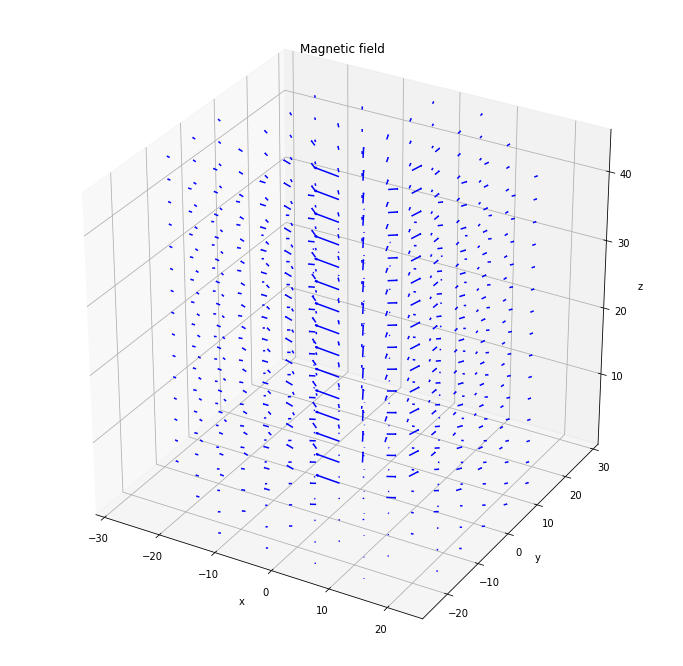

In [196]:
# find min and max
x_min = np.min(np.asarray(positions)[:,:,0])
y_min = np.min(np.asarray(positions)[:,:,1])
z_min = np.min(np.asarray(positions)[:,:,2])

x_max = np.max(np.asarray(positions)[:,:,0])
y_max = np.max(np.asarray(positions)[:,:,1])
z_max = np.max(np.asarray(positions)[:,:,2])

fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')

n_grid = 15

x, y, z = np.meshgrid(np.linspace(x_min, x_max, n_grid),
                      np.linspace(y_min, y_max, n_grid),
                      np.linspace(z_min, z_max, n_grid))

Bx = np.zeros(x.shape)
By = np.zeros(y.shape)
Bz = np.zeros(z.shape)
Btot = np.zeros(x.shape)

for i in range(Bx.shape[0]):
  for j in range(Bx.shape[1]):
    for k in range(Bx.shape[2]):
      Bx[i,j,k] = Bv(x[i,j,k],y[i,j,k],z[i,j,k])[0]
      By[i,j,k] = Bv(x[i,j,k],y[i,j,k],z[i,j,k])[1]
      Bz[i,j,k] = Bv(x[i,j,k],y[i,j,k],z[i,j,k])[2]
      Btot[i,j,k] = np.sqrt(Bx[i,j,k]*Bx[i,j,k] + By[i,j,k]*By[i,j,k] + Bz[i,j,k]*Bz[i,j,k])

color = 'blue'

ax.quiver( x, y, z, Bx/np.max(Btot), By/np.max(Btot), Bz/np.max(Btot), length=0.5*(x_max-x_min)/n_grid, arrow_length_ratio=0.1, color = color)

plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
ax.set_title('Magnetic field')

plt.show()

In [ ]:
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.2)


n_grid=50
X, Y = np.meshgrid(np.linspace(x_min, x_max, n_grid),
                   np.linspace(y_min, y_max, n_grid))

BX = np.zeros(X.shape)
BY = np.zeros(Y.shape)
BZ = np.zeros(Y.shape)
BTOT = np.zeros(Y.shape)

# arrange plots
n_Z = 9
n_Z1= 3
n_Z2= 3

for i in range(n_Z):
  ax = fig.add_subplot(n_Z1, n_Z2, i + 1)
  Z = z_min+(z_max-z_min)/n_Z*i

  for i in range(BX.shape[0]):
    for j in range(BX.shape[1]):
    
      BX[i,j] = Bv(X[i,j],Y[i,j],Z)[0]
      BY[i,j] = Bv(X[i,j],Y[i,j],Z)[1]
      BZ[i,j] = Bv(X[i,j],Y[i,j],Z)[2]
      BTOT[i,j] = np.sqrt(BX[i,j]*BX[i,j] + BY[i,j]*BY[i,j] + BZ[i,j]*BZ[i,j])

  # Plot the streamlines with an appropriate colormap and arrow style
  color = BTOT
  if np.max(BTOT)<0.001:
    color = 'black'
  
  if np.max(BX)>0 or np.max(BY)>0:
    ax.streamplot( X, Y, BX, BY, color=color, linewidth=1, cmap=plt.cm.inferno,
              density=2, arrowstyle='->', arrowsize=1.5, norm=mpl.colors.Normalize(vmin=0,vmax=np.max(Btot)))

  ax.set_xlabel('x')
  ax.set_ylabel('y')
  aux = 'magnetic field, Z = '+str(np.round(Z))
  ax.set_title(aux)

plt.show()